### Imports and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tarfile
import requests
from tqdm.auto import tqdm
import dotenv
import os

dir_path = "../../data/crunchbase"
data_path = dir_path + '/bulk_export.tar.gz'

if not os.path.isdir(dir_path):
    print('Crunchbase data not found. Downloading bulk export...')
    os.makedirs(dir_path)

    API_KEY = dotenv.get_key('.env', "CRUNCHBASE_API_KEY")
    url = f"https://api.crunchbase.com/bulk/v4/bulk_export.tar.gz?user_key={API_KEY}"

    response = requests.get(url, stream=True)
    with open(data_path, "wb") as fout:
        with tqdm(
                unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
                desc='bulk_export.tar.gz', total=int(response.headers.get('content-length', 0))
        ) as pbar:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)
                pbar.update(len(chunk))

    tar = tarfile.open(data_path, "r:gz")
    tar.extractall(dir_path)
    tar.close()

In [3]:
orgs = pd.read_csv("../../data/crunchbase/organizations.csv")
jobs = pd.read_csv("../../data/crunchbase/jobs.csv")
pple = pd.read_csv("../../data/crunchbase/people.csv")
ipos = pd.read_csv("../../data/crunchbase/ipos.csv")
acquisitions = pd.read_csv("../../data/crunchbase/acquisitions.csv")

### Zong et. al data re-creation

In [3]:
N_acquisitions = pd.DataFrame(acquisitions.groupby(["acquirer_uuid", "acquirer_name"]).size()).reset_index()
N_acquisitions.columns = ["uuid", "name", "N_acquisitions"]
N_acquisitions.set_index("uuid", inplace=True)

In [4]:
ONE_MONTH_NS = np.timedelta64(1, 'M')
TODAY_NS = pd.to_datetime('today').normalize()

age = orgs[["uuid", "founded_on"]].dropna().set_index("uuid")
age["founded_on"] = pd.to_datetime(age["founded_on"], errors='coerce')
age = age.loc[(age['founded_on'] >= '1900-09-01')]
age["N_months"] = (TODAY_NS - age["founded_on"]) / ONE_MONTH_NS
age.drop(columns=["founded_on"], inplace=True)

In [5]:
V_monthly_amount = orgs[["uuid", "total_funding_usd"]].dropna()
V_monthly_amount.set_index("uuid", inplace=True)
V_monthly_amount.columns = ["V_monthly_amount"]

In [6]:
N_rounds = orgs[["uuid", "num_funding_rounds"]].dropna()
N_rounds.set_index("uuid", inplace=True)
N_rounds.columns = ["N_rounds"]

In [7]:
values = ['unknown', '1-10', '11-50', '51-100', '101-250', '251-500', '501-1000', '1001-5000', '5001-10000', '10000+']
cats = dict(zip(values, range(len(values))))
N_employees = orgs[["uuid", "employee_count"]].dropna()
N_employees.set_index("uuid", inplace=True)
N_employees.columns = ["N_employees"]
N_employees["N_employees"] = N_employees["N_employees"].apply(lambda x: cats[x])

In [8]:
members = pd.DataFrame(jobs.groupby(["org_uuid", "is_current"]).size())
N_past_members = members[members.index.get_level_values('is_current').isin([False])]
N_past_members = N_past_members.reset_index().drop(columns='is_current').dropna()
N_past_members.set_index('org_uuid', inplace=True)
N_past_members.columns = ['N_past_members']

In [9]:
pple.dropna(subset=['featured_job_title'], inplace=True)
founders = pple[pple['featured_job_title'].apply(lambda x: 'founder' in x.lower())]
N_founders = pd.DataFrame(founders.groupby(['featured_job_organization_uuid']).size()).reset_index()
N_founders.columns = ['uuid', 'N_founders']
N_founders.set_index("uuid", inplace=True)

In [10]:
properties = pd.concat([N_acquisitions, age, N_rounds, V_monthly_amount, N_employees, N_past_members, N_founders], axis=1, join="inner")
properties["F_acquisitions"] = properties["N_acquisitions"] / properties["N_months"]
properties["V_monthly_amount"] = properties["V_monthly_amount"] / properties["N_months"]
properties["F_members_quit"] = properties["N_past_members"] / properties["N_months"]

In [11]:
properties

,name,N_acquisitions,N_months,N_rounds,V_monthly_amount,N_employees,N_past_members,N_founders,F_acquisitions,F_members_quit
0002da99-6654-1ecd-79c6-8064a01ebfa6,Zygo Corporation,1,628.053964,1.0,1.432998e+04,6,4,3,0.001592,0.006369
000de357-21fe-44c8-9f67-42c507644a28,apaleo,1,64.034169,2.0,8.241398e+04,2,1,3,0.015617,0.015617
000f755c-5a63-7936-acf1-d90498b43f0d,Bright Power,1,208.168546,5.0,1.504862e+05,4,2,1,0.004804,0.009608
00244ad2-e3d9-0b2d-05cc-09e12d63c77e,Zenovia Digital Exchange,2,123.895768,2.0,8.910716e+04,2,7,2,0.016143,0.056499
004585f6-70d2-da74-7ff1-9f68a8e1162a,Miro,1,131.090987,4.0,5.820385e+05,6,4,2,0.007628,0.030513
...,...,...,...,...,...,...,...,...,...,...
ffd6f48b-1f7a-dd43-b087-a0a1c1521a1b,Sisense,1,220.062014,7.0,1.245104e+06,6,27,2,0.004544,0.122693
ffd95c72-b34e-acbc-f787-93d277d9c035,Ettain Group,5,316.063985,1.0,0.000000e+00,5,11,2,0.015820,0.034803
ffe232c5-fcf4-e08e-b43d-c7dd1d5fc32c,Checkr,1,100.043122,7.0,5.587591e+06,6,10,2,0.009996,0.099957
ffee57b9-60d2-2294-a50f-57587d521128,GROW,1,88.051089,3.0,2.725690e+04,1,2,1,0.011357,0.022714


MISSING VALUES:
       . Frequency of news on public media
       . Number of competitors (category groups?)
       . Number of products

### Funding rounds data with Cochrane dataset

In [12]:
def is_outlier(points, thresh=5.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [14]:
org_names = orgs[["uuid", "name"]]
org_names.columns = ["org_uuid", "name"]

rounds = pd.read_csv("../../data/crunchbase/funding_rounds.csv")
rounds = rounds[["uuid", "announced_on", "raised_amount_usd", "investor_count", "org_uuid", "post_money_valuation_usd"]]
rounds.dropna(subset=["raised_amount_usd"], inplace=True)
rounds = rounds.merge(org_names, how='left', on="org_uuid")
rounds.sort_values(by="org_uuid", inplace=True)
rounds["announced_on"] = pd.to_datetime(rounds["announced_on"])

In [15]:
v = rounds.org_uuid.value_counts()
more_than_5_rounds = rounds[rounds.org_uuid.isin(v.index[v.ge(5)])].copy()
more_than_5_rounds.set_index(["org_uuid", "uuid"], inplace=True)
counts = more_than_5_rounds.groupby(["org_uuid"]).size()

In [16]:
post_money = rounds.dropna(subset=['post_money_valuation_usd'])
v = post_money.org_uuid.value_counts()
more_than_3_pmv = post_money[post_money.org_uuid.isin(v.index[v.ge(3)])]
more_than_3_pmv.set_index(["org_uuid", "uuid"], inplace=True)

Text(0.5, 0, 'nb. funding rounds')

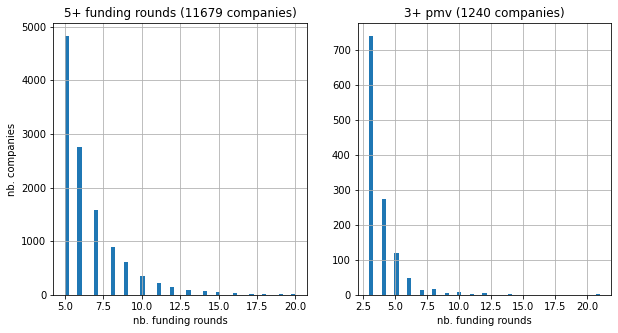

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))


counts[~is_outlier(counts, 10)].hist(bins=55, ax=ax1)
more_than_3_pmv.groupby(["org_uuid"]).size().hist(bins=55, ax=ax2)

ax1.set_title(f"5+ funding rounds ({more_than_5_rounds.index.get_level_values(0).unique().size} companies)")
ax1.set_xlabel("nb. funding rounds")
ax1.set_ylabel("nb. companies")

ax2.set_title(f"3+ pmv ({more_than_3_pmv.index.get_level_values(0).unique().size} companies)")
ax2.set_xlabel("nb. funding rounds")

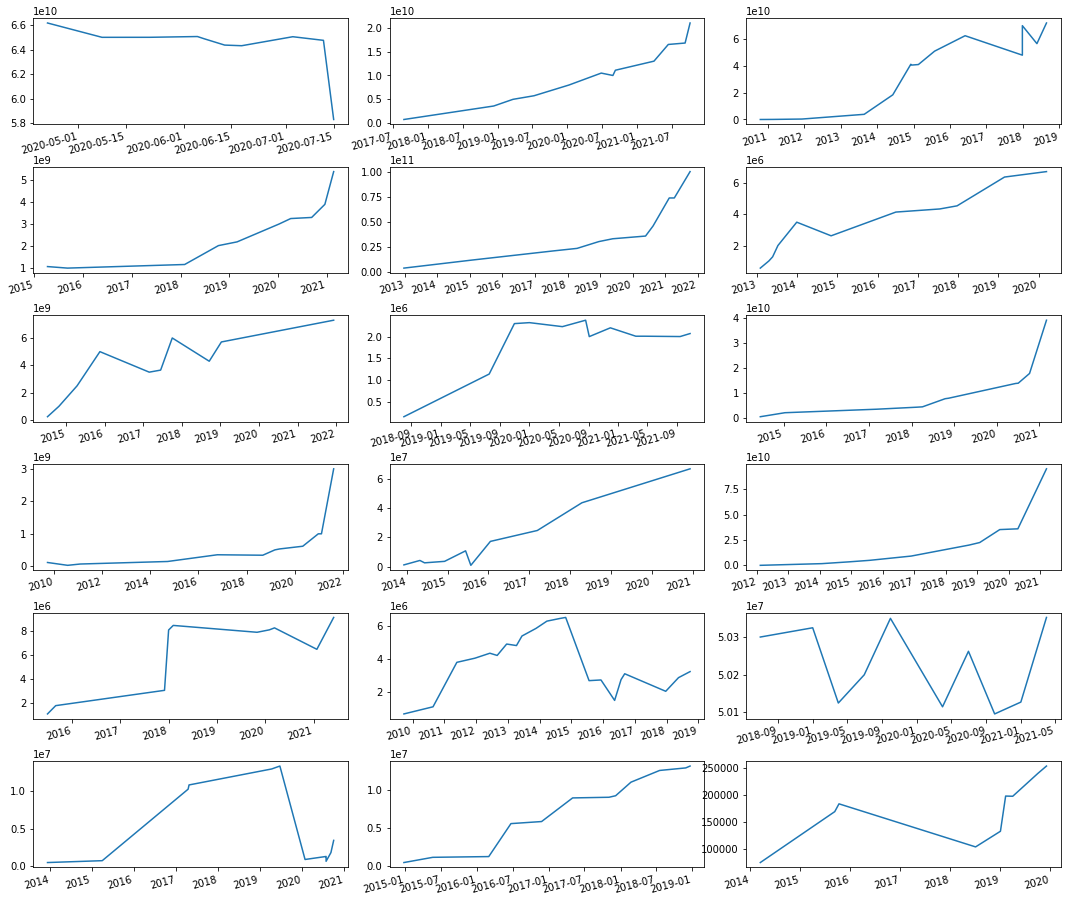

In [18]:
v = post_money.org_uuid.value_counts()
more_than_10_pmv = post_money[post_money.org_uuid.isin(v.index[v.ge(10)])]

def show_pmv(uuid, ax): 
    more_than_10_pmv.loc[more_than_10_pmv.org_uuid == uuid][["announced_on", "post_money_valuation_usd"]].set_index("announced_on").sort_values(by="announced_on").plot(ax=ax, legend=False, rot=15, xlabel='')

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15,15))
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i, uuid in enumerate(more_than_10_pmv.org_uuid.unique()):
    show_pmv(uuid, axs[i//3, i%3])

In [45]:
raised_amount = rounds.raised_amount_usd
log_raised_amount = np.log(raised_amount[raised_amount > 0]).values

valuation = rounds.post_money_valuation_usd
log_valuation = np.log(valuation[valuation > 0]).values

Text(0.5, 0, 'log post money valuation')

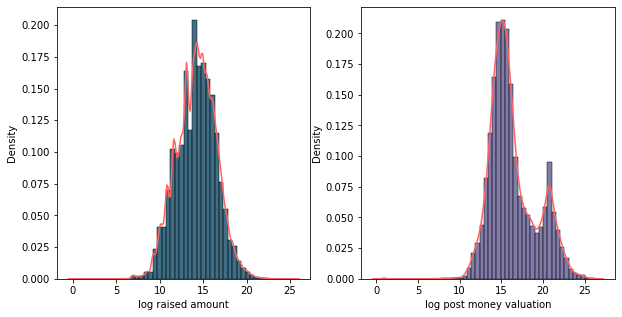

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(log_raised_amount, ax=ax1, stat="density", bins=50, color="#003f5c")
sns.kdeplot(log_raised_amount, color="#ff6361", ax=ax1)
ax1.set_xlabel("log raised amount")

sns.histplot(log_valuation, ax=ax2, stat="density", bins=50, color='#58508d')
sns.kdeplot(log_valuation, color="#ff6361", ax=ax2)
ax2.set_xlabel("log post money valuation")

In [86]:
raised_by_year = rounds.groupby(rounds.announced_on.dt.year).sum()[["raised_amount_usd", "post_money_valuation_usd"]]
raised_by_quarter = rounds.groupby(rounds.announced_on.dt.to_period('Q')).sum()[["raised_amount_usd", "post_money_valuation_usd"]]

raised_by_year = raised_by_year[raised_by_year.index >= 2000]
raised_by_quarter = raised_by_quarter[raised_by_quarter.index >= '2000Q1']

Text(0.5, 0, 'raised amount per quarter')

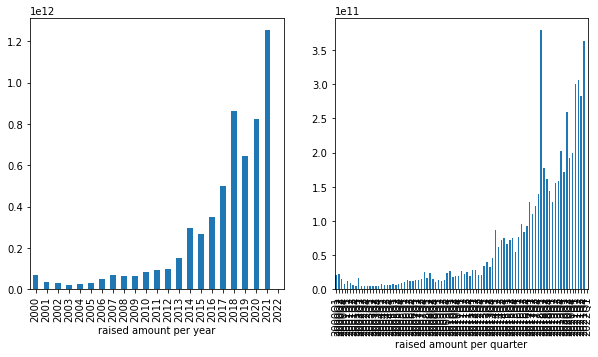

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

raised_by_year.raised_amount_usd.plot(kind='bar', ax=ax1)
ax1.set_xlabel("raised amount per year")

raised_by_quarter.raised_amount_usd.plot(kind='bar', ax=ax2)
ax2.set_xlabel("raised amount per quarter")


### Add in Cochrane data

In [44]:
from hashlib import blake2b

def name_to_uuid(name):
    hash32 = blake2b(name.encode('utf-8'), digest_size=16).hexdigest()
    return hash32[:8] + '-' + hash32[8:12] + '-' + hash32[12:16] + '-' + hash32[16:20] + '-' + hash32[20:]


In [21]:
cochrane_data = pd.read_excel('../../data/cochrane_data/data.xls', skiprows=4)
cochrane_data.drop(columns=['Internet Y/N', 'Internet Dimension', 
                            'CurrentOwnerStat', 'Date', 'Year', 
                            'CurrentBusStat', 'IndustrySegment_Descr', 
                            'IndustryGroup_Descr', 'Class', 
                            'CoRound_BusStat', 'VC Firm Investor'], inplace=True)

cochrane_data['org_uuid'] = cochrane_data.CompanyName.apply(name_to_uuid)
cochrane_data['uuid'] = (cochrane_data.CompanyName + cochrane_data.CloseDate.astype('str') + cochrane_data.PostValue.astype('str')).apply(name_to_uuid)
clean_cochrane = cochrane_data.drop_duplicates(subset=["uuid"]).sort_values(by=["CompanyName", "CloseDate"])

assert set(clean_cochrane.uuid).isdisjoint(set(rounds.uuid)), "Collision founds between Crunchbase and Cochrane uuids"
assert set(clean_cochrane.org_uuid).isdisjoint(set(rounds.org_uuid)), "Collision founds between Crunchbase and Cochrane org uuids"
clean_cochrane.drop(columns=['Quarter', 'Month', 'Year.1', 'Type', 'PreVal', 'IndustryCode_Descr'], inplace=True)
clean_cochrane.columns=["name", "announced_on", "raised_amount_usd", "post_money_valuation_usd", "org_uuid", "uuid"]
clean_cochrane[["raised_amount_usd", "post_money_valuation_usd"]] *= 1e6

In [22]:
full_rounds = pd.concat([clean_cochrane, rounds])
full_rounds

,name,announced_on,raised_amount_usd,post_money_valuation_usd,org_uuid,uuid,investor_count
18983,0-In Design Automation,1997-06-05,3000000.0,NaN,ef98ea2e-b952-7c69-9086-44193cd6c2d9,dde90397-3061-c262-ecda-10e06e745763,NaN
18984,0-In Design Automation,1998-08-15,6300000.0,28000000.0,ef98ea2e-b952-7c69-9086-44193cd6c2d9,39ed1e62-06d0-ebdb-c865-0dd47f65a892,NaN
32967,1 Data Way,2000-03-24,1600000.0,4600000.0,a923ddc9-df1b-f066-c1cb-b5942708764e,2099c465-9d88-f8a5-0472-2506a1b6d9cd,NaN
3600,1-800-FLOWERS.COM,1995-01-01,10000000.0,NaN,952011a3-e8f6-2307-7035-cde57466f94a,bdcf6fe5-b8fe-87e7-c283-85be4a22487b,NaN
3601,1-800-FLOWERS.COM,1999-05-01,14900000.0,NaN,952011a3-e8f6-2307-7035-cde57466f94a,78b260a5-9e84-ec51-970f-5a4bf625028d,NaN
...,...,...,...,...,...,...,...
107857,ERNIT,2015-05-01,80000.0,NaN,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,c09637c8-bbaf-bef0-3ebb-39f50f8063fc,NaN
107858,ERNIT,2015-01-01,15000.0,NaN,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,e56803fc-d1d9-2dcd-77ea-8b555cceb674,1.0
120161,ERNIT,2017-02-09,700000.0,NaN,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,f6dd414e-9ed9-da8d-9260-0385580d81b3,2.0
107859,ERNIT,2015-09-15,82000.0,NaN,ffffabce-6d4a-b3d1-13c0-4e90cedf5270,1776a3c6-335b-ae77-3315-624019adfa5f,NaN


In [29]:
def f(x, t):
    return x.isna().sum() / x.size < t and x.size > 1

full_rounds = pd.concat([clean_cochrane, rounds])
full_rounds = full_rounds.sort_values(by=["org_uuid", "announced_on"])
full_rounds.reset_index(inplace=True, drop=True)

full_rounds = full_rounds.loc[full_rounds.groupby('org_uuid')['post_money_valuation_usd'].filter(lambda x: f(x, 0.25)).index]

returns = full_rounds[["org_uuid", "post_money_valuation_usd"]].groupby("org_uuid").apply(lambda group: group.pct_change())
returns.replace([np.inf, -np.inf, -1], np.nan, inplace=True)
full_rounds["ret"] = returns

full_rounds.drop(columns=["investor_count", "org_uuid", "uuid"], inplace=True)

### Create crunchbase dataset

In [33]:
rounds.drop(columns=["investor_count"], inplace=True)

In [35]:
acquisitions = pd.read_csv("../../data/crunchbase/acquisitions.csv")
ipos = pd.read_csv("../../data/crunchbase/ipos.csv")
ipos.drop(columns=['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'org_name', 'org_cb_url', 'country_code',
       'state_code', 'region', 'city', 'stock_exchange_symbol', 'stock_symbol',
       'share_price_usd', 'share_price',
       'share_price_currency_code', 'valuation_price',
       'valuation_price_currency_code', 'money_raised_usd', 'money_raised',
       'money_raised_currency_code'], inplace=True)
acquisitions.drop(columns=['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at',
       'updated_at', 'acquiree_cb_url', 'acquiree_name',
       'acquiree_country_code', 'acquiree_state_code', 'acquiree_region',
       'acquiree_city', 'acquirer_uuid', 'acquirer_name', 'acquirer_cb_url',
       'acquirer_country_code', 'acquirer_state_code', 'acquirer_region',
       'acquirer_city', 'acquisition_type',
       'price', 'price_currency_code'], inplace=True)

ipos.columns = ['org_uuid', 'exit_date', 'exit_value']
acquisitions.columns = ['org_uuid', 'exit_date', 'exit_value']

closings = pd.DataFrame(orgs[['uuid', 'closed_on']].dropna())
closings.columns = ['org_uuid', 'exit_date']


In [36]:
ipos["exit_type"] = 1
acquisitions["exit_type"] = 2
closings["exit_type"] = 3
closings["exit_value"] = np.nan

In [37]:
exits = pd.concat([acquisitions, ipos, closings]).set_index("org_uuid")

rounds["exit_value"] = rounds.org_uuid.map(exits["exit_value"].to_dict())
rounds["exit_date"] = pd.to_datetime(rounds.org_uuid.map(exits["exit_date"].to_dict()))
rounds["exit_type"] = rounds.org_uuid.map(exits["exit_type"].to_dict()).fillna(value=4).astype(int)

In [38]:
def to_int_date(date):
    if date != -99:
        return int(str(date)[:10].replace('-','')) 
    else:
        return -99


final = rounds.drop(columns=['uuid', 'name'])
final["return_usd"] = final[["org_uuid", "post_money_valuation_usd"]].groupby("org_uuid").apply(lambda group: group.pct_change())
final.columns = ['round_date', 'raised_usd', 'company_num', 'postvalue_usd', 'exit_value', 'exit_type', 'exit_date', 'return_usd']
final.fillna(-99, inplace=True)

In [39]:
final.exit_date = final.exit_date.apply(to_int_date)
final.round_date = final.round_date.apply(to_int_date)

In [40]:
companies = final.company_num.unique()
company_to_num = dict(zip(companies, range(len(companies))))
final.company_num = final.company_num.map(company_to_num)

final['group_num'] = np.nan
final['seg_num'] = np.nan
final['flagpct'] = 0

In [41]:
final['flagpct'] = 0
final = final[['company_num', 'group_num', 'seg_num', 'round_date', 'raised_usd', 'postvalue_usd', 'exit_date', 'exit_type', 'exit_value', 'return_usd', 'flagpct']]

In [42]:
final

,company_num,group_num,seg_num,round_date,raised_usd,postvalue_usd,exit_date,exit_type,exit_value,return_usd,flagpct
138728,0,NaN,NaN,20170717,82607364.0,-99.0,2,2017-05-12 00:00:00,-99.0,-99.0,0
116457,1,NaN,NaN,20161214,1600000.0,-99.0,4,-99,-99.0,-99.0,0
51751,1,NaN,NaN,20140324,600000.0,-99.0,4,-99,-99.0,-99.0,0
33581,1,NaN,NaN,20130805,118000.0,-99.0,4,-99,-99.0,-99.0,0
82551,1,NaN,NaN,20150826,1200000.0,-99.0,4,-99,-99.0,-99.0,0
...,...,...,...,...,...,...,...,...,...,...,...
107857,167400,NaN,NaN,20150501,80000.0,-99.0,4,-99,-99.0,-99.0,0
107858,167400,NaN,NaN,20150101,15000.0,-99.0,4,-99,-99.0,-99.0,0
120161,167400,NaN,NaN,20170209,700000.0,-99.0,4,-99,-99.0,-99.0,0
107859,167400,NaN,NaN,20150915,82000.0,-99.0,4,-99,-99.0,-99.0,0
